
# Neural-HMM synthesis notebook

## Location of the model checkpoints

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 3

## Import libraries and setup matplotlib

In [3]:
import matplotlib.pylab as plt

# Download tokenizer if not present
import nltk
nltk.download('punkt')

import IPython.display as ipd 
import os
import json
import sys
sys.path.append('src/model')
sys.path.insert(0, './hifigan')
import numpy as np
import torch

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import text_to_sequence, phonetise_text
from hifigan.env import AttrDict
from hifigan.models import Generator
from nltk import word_tokenize
from hifigandenoiser import Denoiser
%matplotlib inline



[nltk_data] Downloading package punkt to /home/smehta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
%ls checkpoints/Rel_Attention_TestNoPos/

checkpoint_0.ckpt  checkpoint_500.ckpt


In [7]:
checkpoint_path = "checkpoints/Rel_Attention_TestNoPos/checkpoint_500.ckpt"

## Plotting code

In [8]:
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_states)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

## Setup hparams

In [9]:
hparams = create_hparams()

## Load model from checkpoint

In [10]:
# x = torch.load(checkpoint_path, map_location="cuda")
# x['hyper_parameters']['rel_attention'] = True
# torch.save(x, checkpoint_path)

In [11]:
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 34,957,185 trainable parameters


## Load Hifi-gan for mel2audio synthesis and denoiser

In [13]:
def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

In [14]:
# load the hifi-gan model
hifigan_loc = 'hifigan/'
config_file = hifigan_loc + 'config_v1.json'
hifi_checkpoint_file = 'g_02500000'
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)

In [15]:
h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(hifi_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval().half()
generator.remove_weight_norm()

denoiser = Denoiser(generator, mode='zeros')

g_02500000
Loading 'g_02500000'
Complete.
Removing weight norm...


### Usage
1. Increase max_sampling_time for longer utterances
2. Increase duration_quantile_threshold for faster speaking rate
3. Set deterministic_transaction as False for model sampled transition probabilities
4. Set predict_means to False to synthesis a sample instead of just means of gaussians
5. Set prenet_dropout_while_eval to False to turn off dropout in the prenet module

In [34]:
model.model.hmm.hparams.max_sampling_time = 10000
model.model.hmm.hparams.duration_quantile_threshold=0.5
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=False
model.model.hmm.hparams.prenet_dropout_while_eval=True

## Set texts

In [35]:
texts = [
    "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS .."
]

In [50]:
test_sentences = {
    1: "; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW.",
    2: "THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON.",
    3: "WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW.",
    4: "IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND.",
    5: "THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS.",
    6: "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS.",
    7: "IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS.",
    8: "IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS.",
    9: "IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING.",
    10: "DISTILLING INTELLIGENCE INTO AN ALGORITHMIC CONSTRUCT AND COMPARING IT TO THE HUMAN BRAIN MIGHT YIELD INSIGHTS.",
    11: "THE VAULT THAT WAS SEARCHED HAD IN FACT BEEN EMPTIED EARLIER THAT SAME DAY.",
    12: "ANT LIVES NEXT TO GRASSHOPPER, ANT SAYS, I LIKE TO WORK EVERY DAY.",
    13: "YOUR MEANS OF TRANSPORT FULFIL ECONOMIC REQUIREMENTS IN YOUR CHOSEN COUNTRY.",
    14: "SLEEP STILL FOGGED MY MIND AND ATTEMPTED TO FIGHT BACK THE PANIC.",
    15: "SUDDENLY, I SAW TWO FAST AND FURIOUS ; FEET DRIBBLING THE ; BALL TOWARDS MY GOAL.",
}

texts = [" ".join(test_sentences.values())]

In [48]:
texts = [
    "We propose a new approach, OverFlow, to address the shortcomings of neural HMM TTS (a type of transducer TTS) by adding flows over them. Having a stronger probabilistic model, we can now describe the highly non-Gaussian distribution of speech acoustics, WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS."
]

In [51]:
sequences = []

for i, text in enumerate(texts):
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Input text: \n{''.join(['*'] * 20)}\n{text}")
    text = phonetise_text(hparams.cmu_phonetiser, text, word_tokenize)
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Phonetised text: \n{''.join(['*'] * 20)}\n{text}")
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).to(device).long()
    sequences.append(sequence)
    
    print(''.join(['='] * 100))


********************
1 - Input text: 
********************
; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON. WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW. IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND. THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS. THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS. IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS. IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIE

## Decode text input and plot results

In [52]:
t = 0.334

In [53]:
from tqdm.auto import tqdm
with torch.no_grad():
    mel_outputs, hidden_state_travelled_all = [], []
    for sequence in tqdm(sequences, leave=False):
        mel_output, hidden_state_travelled, _, _ = model.sample(sequence.squeeze(0), sampling_temp=t)
        mel_outputs.append(mel_output)
        hidden_state_travelled_all.append(hidden_state_travelled)
        

  0%|          | 0/1 [00:00<?, ?it/s]

### Visualisations of the output

0 ; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON. WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW. IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND. THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS. THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS. IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS. IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING. DISTILLING INTELLIGENCE INTO AN ALGORI

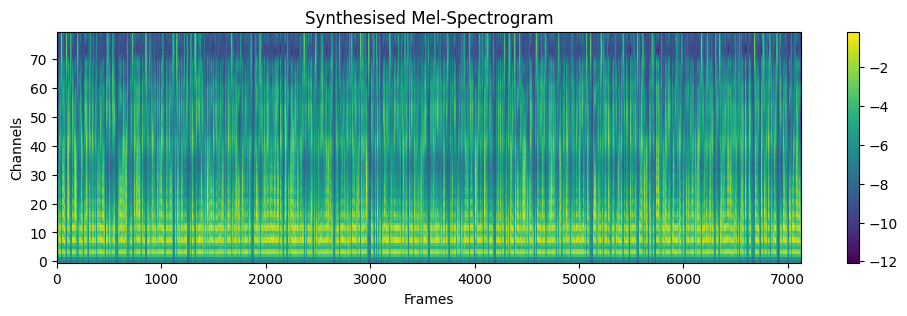

In [54]:
for i, mel_output in enumerate(mel_outputs):
    print(i, texts[i])
    plot_spectrogram_to_numpy(np.array(mel_output.float().cpu()).T)

### Synthesize audio from spectrogram using HiFiGAN

### Interesting denoising

In [55]:
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = mel_output.transpose(1, 2)
        audio = generator(mel_output)
        audio = denoiser(audio[:, 0], strength=0.004)[:, 0]
        audios.append(audio)
        print(f"{''.join(['*'] * 10)} \t{i + 1}\t {''.join(['*'] * 10)}")
        print(f"Text: {texts[i]}")
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        print(f"{''.join(['*'] * 35)}\n")


********** 	1	 **********
Text: ; WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON. WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW. IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND. THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS. THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS. IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS. IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING. DISTILLI

***********************************



### Save to wav files using soundfile

In [ ]:
import soundfile as sf
from pathlib import Path

basepath = Path('synthesised_wavs')
basepath.mkdir(parents=True, exist_ok=True)

for i, audio in enumerate(audios):
        filename = basepath / f'OverFlow_{i + 1}.wav'
        sr = 22500
        sf.write(filename, audio.data.squeeze().cpu().numpy(), 
                 22500, 'PCM_24')
        print(f'Successfully written: {filename}')
